# Análise das Reviews do APP

## Bibliotecas usadas

In [1]:
import nltk
import random
import unidecode
import regex as re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk import ngrams
from nltk import tokenize
from wordcloud import WordCloud
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

## Funções auxiliares

In [2]:
def pareto(texto, coluna_texto, quantidade):
    todas_palavras = " ".join([texto for texto in texto[coluna_texto]])

    token_espaco = tokenize.WhitespaceTokenizer()
    token_frase = token_espaco.tokenize(todas_palavras)

    frequencia = nltk.FreqDist(token_frase)
    
    df_frequencia = pd.DataFrame({"Palavra" : list(frequencia.keys()), 
                                  "Frequencia" : list(frequencia.values())})

    palavras_mais_recorrentes = df_frequencia.nlargest(columns="Frequencia", n=quantidade+1)
    palavras_mais_recorrentes = palavras_mais_recorrentes[1:]
    
    plt.figure(figsize=(12,8))
    sns.barplot(data=palavras_mais_recorrentes, x="Palavra", y="Frequencia", color='gray')

def nuvem_pos(df, coluna):
    df_pos = df.query("Sentiment == 'Positive'")
    
    todas_palavras = " ".join([texto for texto in df_pos[coluna]])

    nuvem_palavras = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(todas_palavras)

    plt.figure(figsize=(12,8))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.show()
    
def nuvem_neg(df, coluna):
    df_neg = df.query("Sentiment == 'Negative'")
    
    todas_palavras = " ".join([texto for texto in df_neg[coluna]])

    nuvem_palavras = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(todas_palavras)

    plt.figure(figsize=(12,8))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.show()
    
def nuvem_net(df, coluna):
    df_neg = df.query("Sentiment == 'Neutral'")
    
    todas_palavras = " ".join([texto for texto in df_neg[coluna]])

    nuvem_palavras = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(todas_palavras)

    plt.figure(figsize=(12,8))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.show()

def remover(textos, regex):
    if type(textos) == str:
        return regex.sub("", textos)
    else:
        return [regex.sub("", texto) for texto in textos]
    
def substituir_por_espaco(textos, regex):
    if type(textos) == str:
        return regex.sub(" ", textos)
    else:
        return [regex.sub(" ", texto) for texto in textos]
    
def imprime_resultados(resultados):
    media = resultados['test_score'].mean()
    desvio_padrao = resultados['test_score'].std()
    print("Precisão Média: {:.2f}%".format(media*100))
    print("O intervalo de precisão: {:.2f}% a {:.2f}%".format(((media-2*desvio_padrao)*100), ((media+2*desvio_padrao)*100)))

## Leitura e limpeza do Dataset

In [3]:
xls = pd.ExcelFile('datasets/data_scientist_-_case_1_1_1.xlsx')
df = pd.read_excel(xls, sheet_name=1)

display(df.head())
display(df.shape)

,Package Name,App Version Name,Reviewer Language,Device,Review Last Update Date and Time,Star Rating,Review Title,Review Text,Sentiment,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Row Labels,Average of Star Rating,Count of Star Rating
0,B4 Bank,6.10.6,pt,greatlte,2019-10-01T00:09:07Z,5,NaN,NaN,Positive,NaN,NaN,NaN,NaN,4.1.14,5.0,1.0
1,B4 Bank,6.10.6,pt,mido,2019-10-01T00:18:49Z,5,NaN,NaN,Positive,NaN,NaN,NaN,NaN,4.1.17,3.0,1.0
2,B4 Bank,6.10.6,pt,on5xelte,2019-10-01T00:34:35Z,5,NaN,Boa,Positive,NaN,NaN,NaN,NaN,4.1.7,5.0,2.0
3,B4 Bank,6.10.6,pt,dreamlte,2019-10-01T00:44:18Z,2,NaN,"Não consigo gerar a fatura em PDF, no mesmo fo...",Negative,NaN,NaN,NaN,NaN,4.1.8,5.0,1.0
4,B4 Bank,6.10.6,pt,starqltechn,2019-10-01T01:09:56Z,4,NaN,NaN,Positive,NaN,NaN,NaN,NaN,5.0.7,4.0,1.0


(5679, 16)

### Informações gerais do Dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5679 entries, 0 to 5678
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Package Name                      5679 non-null   object 
 1   App Version Name                  5423 non-null   object 
 2   Reviewer Language                 5679 non-null   object 
 3   Device                            5673 non-null   object 
 4   Review Last Update Date and Time  5679 non-null   object 
 5   Star Rating                       5679 non-null   int64  
 6   Review Title                      1 non-null      object 
 7   Review Text                       2756 non-null   object 
 8   Sentiment                         1428 non-null   object 
 9   Unnamed: 9                        0 non-null      float64
 10  Unnamed: 10                       0 non-null      float64
 11  Unnamed: 11                       0 non-null      float64
 12  Unname

Análise da quantidade de dados faltantes e tipos de cada feature.

In [5]:
df.isna().sum()

Package Name                           0
App Version Name                     256
Reviewer Language                      0
Device                                 6
Review Last Update Date and Time       0
Star Rating                            0
Review Title                        5678
Review Text                         2923
Sentiment                           4251
Unnamed: 9                          5679
Unnamed: 10                         5679
Unnamed: 11                         5679
Unnamed: 12                         5679
Row Labels                          5628
Average of Star Rating              5628
Count of Star Rating                5628
dtype: int64

2923 clientes não deixaram uma avaliação escrita para o APP.

### Remoção de colunas vazias

In [6]:
df = df.drop(columns=["Unnamed: 9", "Unnamed: 10", "Unnamed: 11", "Unnamed: 12", "Review Title"])

df.head()

,Package Name,App Version Name,Reviewer Language,Device,Review Last Update Date and Time,Star Rating,Review Text,Sentiment,Row Labels,Average of Star Rating,Count of Star Rating
0,B4 Bank,6.10.6,pt,greatlte,2019-10-01T00:09:07Z,5,NaN,Positive,4.1.14,5.0,1.0
1,B4 Bank,6.10.6,pt,mido,2019-10-01T00:18:49Z,5,NaN,Positive,4.1.17,3.0,1.0
2,B4 Bank,6.10.6,pt,on5xelte,2019-10-01T00:34:35Z,5,Boa,Positive,4.1.7,5.0,2.0
3,B4 Bank,6.10.6,pt,dreamlte,2019-10-01T00:44:18Z,2,"Não consigo gerar a fatura em PDF, no mesmo fo...",Negative,4.1.8,5.0,1.0
4,B4 Bank,6.10.6,pt,starqltechn,2019-10-01T01:09:56Z,4,NaN,Positive,5.0.7,4.0,1.0


### Análise da distribuição dos dados faltantes

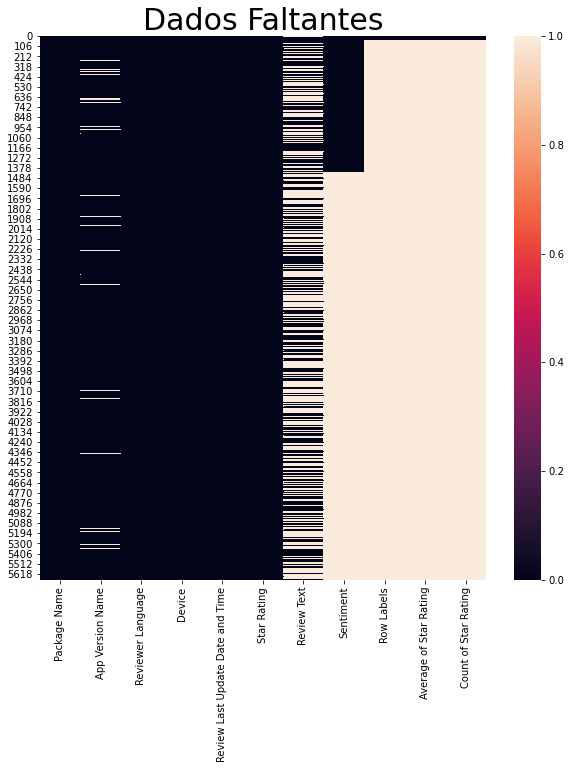

In [7]:
plt.figure(figsize=(10,10))
plt.title("Dados Faltantes", size=30)
sns.heatmap(df.isna());

### Separação do Dataset com os dados gerais das versões do APP

In [8]:
df_versions = df[["Row Labels", "Average of Star Rating", "Count of Star Rating"]]
df_versions = df_versions.dropna()
df_versions.head()

,Row Labels,Average of Star Rating,Count of Star Rating
0,4.1.14,5.0,1.0
1,4.1.17,3.0,1.0
2,4.1.7,5.0,2.0
3,4.1.8,5.0,1.0
4,5.0.7,4.0,1.0


In [9]:
df = df.drop(columns=["Row Labels", "Average of Star Rating", "Count of Star Rating"])
df.head()

,Package Name,App Version Name,Reviewer Language,Device,Review Last Update Date and Time,Star Rating,Review Text,Sentiment
0,B4 Bank,6.10.6,pt,greatlte,2019-10-01T00:09:07Z,5,NaN,Positive
1,B4 Bank,6.10.6,pt,mido,2019-10-01T00:18:49Z,5,NaN,Positive
2,B4 Bank,6.10.6,pt,on5xelte,2019-10-01T00:34:35Z,5,Boa,Positive
3,B4 Bank,6.10.6,pt,dreamlte,2019-10-01T00:44:18Z,2,"Não consigo gerar a fatura em PDF, no mesmo fo...",Negative
4,B4 Bank,6.10.6,pt,starqltechn,2019-10-01T01:09:56Z,4,NaN,Positive


## Dataset com os dados de reviews escritas

In [10]:
df = df.dropna(subset=['Review Text'])
display(df)

,Package Name,App Version Name,Reviewer Language,Device,Review Last Update Date and Time,Star Rating,Review Text,Sentiment
2,B4 Bank,6.10.6,pt,on5xelte,2019-10-01T00:34:35Z,5,Boa,Positive
3,B4 Bank,6.10.6,pt,dreamlte,2019-10-01T00:44:18Z,2,"Não consigo gerar a fatura em PDF, no mesmo fo...",Negative
5,B4 Bank,6.10.6,pt,ASUS_Z012D,2019-10-01T01:25:26Z,4,Atende bem!,Positive
7,B4 Bank,6.10.6,pt,albus,2019-10-01T01:55:51Z,5,Rápido e prático,Positive
8,B4 Bank,6.10.6,pt,j5lte,2019-10-01T02:14:23Z,5,Rapidez,Positive
...,...,...,...,...,...,...,...,...
5670,B4 Bank,6.10.5,pt,beyond0,2019-08-31T20:05:33Z,5,Prático e rápido.,NaN
5673,B4 Bank,6.10.5,pt,a30,2019-08-31T21:48:35Z,5,Sempre nota 10,NaN
5674,B4 Bank,6.10.5,pt,hlte,2019-08-31T21:51:26Z,1,"Baixei a última versão recentemente, ainda não...",NaN
5677,B4 Bank,6.10.5,pt,K10a40,2019-08-31T23:39:14Z,5,"Gostei muito prático, descomplicado",NaN


### Uma primeira vizualização das palavras que mais aparecem nas reviews

159668

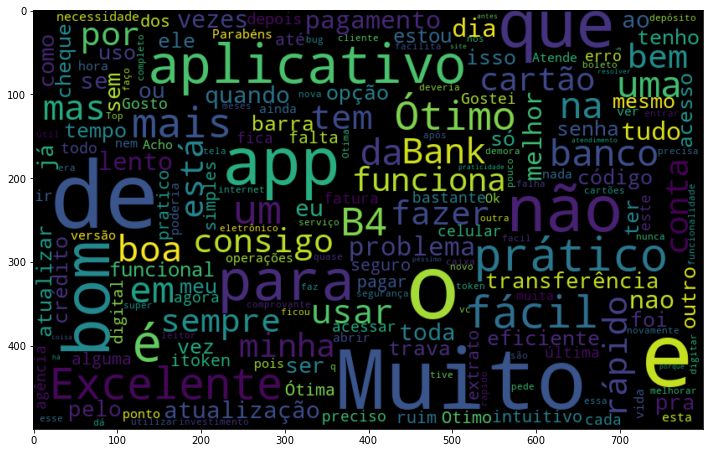

In [11]:
todas_palavras = " ".join([texto for texto in df["Review Text"]])
display(len(todas_palavras))

nuvem_palavras = WordCloud(width=800, 
                           height=500, 
                           max_font_size=110, 
                           collocations=False).generate(todas_palavras)

plt.figure(figsize=(12,8))
plt.imshow(nuvem_palavras, interpolation='bilinear')
plt.show()

Temos um total de 159668 palavras.

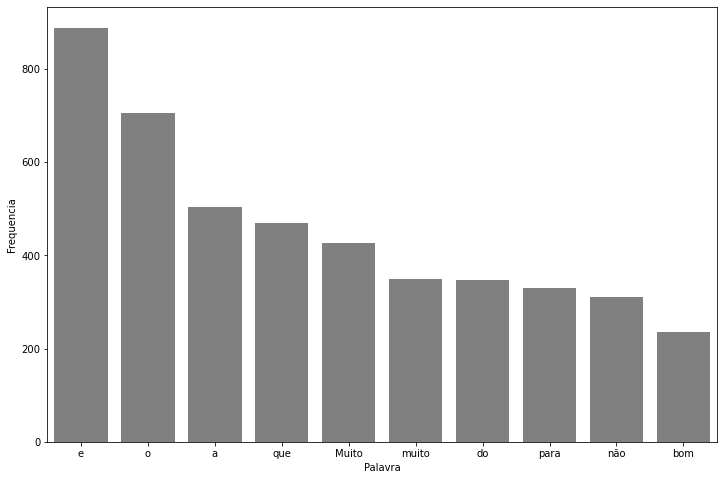

In [12]:
pareto(df, "Review Text", 10)

Podemos ver que as palavras que mais aparecem não dizem muito sobre o contexto geral que estamos analisando.

## Construção de um Dataframe para modelar os dados

In [13]:
df_texto = df[["App Version Name", "Star Rating", "Review Text", "Sentiment"]]
df_texto.head()

,App Version Name,Star Rating,Review Text,Sentiment
2,6.10.6,5,Boa,Positive
3,6.10.6,2,"Não consigo gerar a fatura em PDF, no mesmo fo...",Negative
5,6.10.6,4,Atende bem!,Positive
7,6.10.6,5,Rápido e prático,Positive
8,6.10.6,5,Rapidez,Positive


In [14]:
df_texto.isna().sum()

App Version Name     117
Star Rating            0
Review Text            0
Sentiment           2038
dtype: int64

In [15]:
df_texto["Sentiment"] = df_texto["Star Rating"].replace([5, 4, 3, 2, 1], 
                                                        ["Positive", "Positive", "Neutral", "Negative", "Negative"])
df_texto["Class"] = df_texto.Sentiment.replace(["Negative", "Positive", "Neutral"], [-1, 1, 0])

df_texto

<ipython-input-15-24df25d8cb22>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_texto["Sentiment"] = df_texto["Star Rating"].replace([5, 4, 3, 2, 1],
<ipython-input-15-24df25d8cb22>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_texto["Class"] = df_texto.Sentiment.replace(["Negative", "Positive", "Neutral"], [-1, 1, 0])


,App Version Name,Star Rating,Review Text,Sentiment,Class
2,6.10.6,5,Boa,Positive,1
3,6.10.6,2,"Não consigo gerar a fatura em PDF, no mesmo fo...",Negative,-1
5,6.10.6,4,Atende bem!,Positive,1
7,6.10.6,5,Rápido e prático,Positive,1
8,6.10.6,5,Rapidez,Positive,1
...,...,...,...,...,...
5670,6.10.5,5,Prático e rápido.,Positive,1
5673,6.10.5,5,Sempre nota 10,Positive,1
5674,6.10.5,1,"Baixei a última versão recentemente, ainda não...",Negative,-1
5677,6.10.5,5,"Gostei muito prático, descomplicado",Positive,1


In [16]:
df_texto["App Version Name"].value_counts(normalize=True).sort_index(ascending=False)

6.9.9     0.002274
6.9.8     0.014020
6.9.5     0.001516
6.9.3     0.006442
6.9.2     0.003031
6.9.0     0.000379
6.8.9     0.004547
6.8.8     0.004547
6.8.7     0.001516
6.8.5     0.000379
6.7.9     0.001137
6.7.8     0.001895
6.7.6     0.000758
6.7.2     0.000758
6.6.8     0.000758
6.6.3     0.000379
6.6.11    0.000758
6.5.7     0.000379
6.5.5     0.000379
6.5.10    0.000379
6.4.3     0.000758
6.2.5     0.000379
6.11.1    0.020083
6.10.9    0.056082
6.10.8    0.017431
6.10.7    0.003031
6.10.6    0.378552
6.10.5    0.206897
6.10.4    0.002653
6.10.3    0.208033
6.10.2    0.001895
6.10.1    0.002274
6.10.0    0.054187
6.1.9     0.000379
6.1.4     0.000379
5.0.7     0.000379
4.1.8     0.000379
Name: App Version Name, dtype: float64

#### Exemplo de uma review antes de aplicarmos o tratamento textual

In [17]:
sample = df_texto["Review Text"].tolist()
print(sample[1])

Não consigo gerar a fatura em PDF, no mesmo formato/layout que recebia pelo correio. Assim fica difícil ser um cliente digital =/


### Token para "separar" as palavras

In [18]:
token_pontuacao = tokenize.WordPunctTokenizer()

### Tratamento para transformar o texto das reviews em minúsculo

In [19]:
frase_processada_min = list()

for opiniao in df_texto["Review Text"]:
    nova_frase = list()
    opiniao = opiniao.lower()
    palavra_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavra_texto:
        nova_frase.append(palavra)
            
    frase_processada_min.append(" ".join(nova_frase))
    
df_texto["Trat_Min"] = frase_processada_min

df_texto.head()

<ipython-input-19-69a1bdfea9a3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_texto["Trat_Min"] = frase_processada_min


,App Version Name,Star Rating,Review Text,Sentiment,Class,Trat_Min
2,6.10.6,5,Boa,Positive,1,boa
3,6.10.6,2,"Não consigo gerar a fatura em PDF, no mesmo fo...",Negative,-1,"não consigo gerar a fatura em pdf , no mesmo f..."
5,6.10.6,4,Atende bem!,Positive,1,atende bem !
7,6.10.6,5,Rápido e prático,Positive,1,rápido e prático
8,6.10.6,5,Rapidez,Positive,1,rapidez


### Remoção da pontuação presente no texto

In [20]:
regex_pontuacao = re.compile(r"[^\w\s]")

review_sem_pontuacao = remover(df_texto["Trat_Min"], regex_pontuacao)

display(review_sem_pontuacao[:3])

df_texto["Trat_Pont"] = review_sem_pontuacao

['boa',
 'não consigo gerar a fatura em pdf  no mesmo formato  layout que recebia pelo correio  assim fica difícil ser um cliente digital ',
 'atende bem ']

<ipython-input-20-04dd79ecc17f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_texto["Trat_Pont"] = review_sem_pontuacao


### Remoção de espaços duplos que ficaram após o tratamento da pontuação

In [21]:
regex_espaco = re.compile(r" +")

review_sem_espaco_duplo = substituir_por_espaco(df_texto["Trat_Pont"], regex_espaco)

display(review_sem_espaco_duplo[:3])

df_texto["Trat_Espc"] = review_sem_espaco_duplo

['boa',
 'não consigo gerar a fatura em pdf no mesmo formato layout que recebia pelo correio assim fica difícil ser um cliente digital ',
 'atende bem ']

### Remoção de acento presente no texto

In [22]:
review_sem_acentos = [unidecode.unidecode(texto) for texto in df_texto["Trat_Espc"]]

display(review_sem_acentos[:3])

df_texto["Trat_Acent"] = review_sem_acentos

['boa',
 'nao consigo gerar a fatura em pdf no mesmo formato layout que recebia pelo correio assim fica dificil ser um cliente digital ',
 'atende bem ']

### Remoção de palavras que não agregam muito valor para o contexto

Para isso vamos usar a lista de stop_words do português presente no NLTK

In [23]:
palavras_irrelevantes = nltk.corpus.stopwords.words("portuguese")

palavras_irrelevantes_sem_acento = [unidecode.unidecode(texto) for texto in palavras_irrelevantes]

palavras_irrelevantes_sem_acento.pop(12);

palavras_irrelevantes_sem_acento.append("app")
palavras_irrelevantes_sem_acento.append("aplicativo")

In [24]:
review_stopwords_sem_acento = list()

for opiniao in df_texto["Trat_Acent"]:
    nova_frase = list()
    
    palavra_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavra_texto:
        if palavra not in palavras_irrelevantes_sem_acento:
            nova_frase.append(palavra)
            
    review_stopwords_sem_acento.append(" ".join(nova_frase))
    
df_texto["Trat_Stop"] = review_stopwords_sem_acento

In [25]:
df_texto.head()

,App Version Name,Star Rating,Review Text,Sentiment,Class,Trat_Min,Trat_Pont,Trat_Espc,Trat_Acent,Trat_Stop
2,6.10.6,5,Boa,Positive,1,boa,boa,boa,boa,boa
3,6.10.6,2,"Não consigo gerar a fatura em PDF, no mesmo fo...",Negative,-1,"não consigo gerar a fatura em pdf , no mesmo f...",não consigo gerar a fatura em pdf no mesmo fo...,não consigo gerar a fatura em pdf no mesmo for...,nao consigo gerar a fatura em pdf no mesmo for...,nao consigo gerar fatura pdf formato layout re...
5,6.10.6,4,Atende bem!,Positive,1,atende bem !,atende bem,atende bem,atende bem,atende bem
7,6.10.6,5,Rápido e prático,Positive,1,rápido e prático,rápido e prático,rápido e prático,rapido e pratico,rapido pratico
8,6.10.6,5,Rapidez,Positive,1,rapidez,rapidez,rapidez,rapidez,rapidez


In [40]:
df_texto.to_excel('output.xlsx')

In [26]:
sample_init = df_texto["Review Text"].tolist()
sample_trat = df_texto["Trat_Stop"].tolist()
print(f"Exemplo inicial:\n----------------\n{sample_init[1]}\n")
print(f"Exemplo pós tratamento:\n-----------------------\n{sample_trat[1]}\n")

Exemplo inicial:
----------------
Não consigo gerar a fatura em PDF, no mesmo formato/layout que recebia pelo correio. Assim fica difícil ser um cliente digital =/

Exemplo pós tratamento:
-----------------------
nao consigo gerar fatura pdf formato layout recebia correio assim fica dificil ser cliente digital



In [27]:
stemmer = nltk.RSLPStemmer()

frase_processada_stemmer = list()

for opiniao in df_texto["Trat_Stop"]:
    nova_frase = list()
    #opiniao = opiniao.lower()
    palavra_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavra_texto:
        # Aplicação do stemmer na palavra
        nova_frase.append(stemmer.stem(palavra))
            
    frase_processada_stemmer.append(" ".join(nova_frase))
    
df_texto["Trat_Stm"] = frase_processada_stemmer

In [28]:
sample_init = df_texto["Review Text"].tolist()
sample_trat = df_texto["Trat_Stm"].tolist()
print(f"Exemplo inicial:\n----------------\n{sample_init[1]}\n")
print(f"Exemplo pós tratamento:\n-----------------------\n{sample_trat[1]}\n")

Exemplo inicial:
----------------
Não consigo gerar a fatura em PDF, no mesmo formato/layout que recebia pelo correio. Assim fica difícil ser um cliente digital =/

Exemplo pós tratamento:
-----------------------
nao consig ger fatur pdf format layout receb correi assim fic dificil ser client digit



## Vizualização das principais palavras presentes em todos os textos após o tratamento

115083

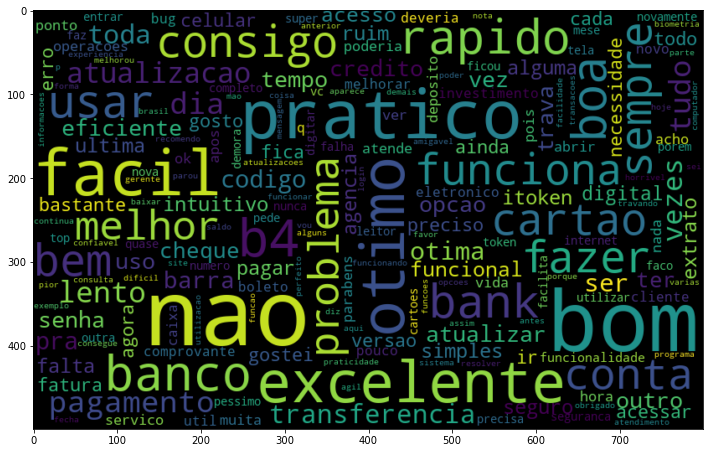

In [29]:
todas_palavras = " ".join([texto for texto in df_texto["Trat_Stop"]])
display(len(todas_palavras))

nuvem_palavras = WordCloud(width=800, 
                           height=500, 
                           max_font_size=110, 
                           collocations=False).generate(todas_palavras)

plt.figure(figsize=(12,8))
plt.imshow(nuvem_palavras, interpolation='bilinear')
plt.show()

Já no contexto geral das reviews conseguimos analisar que muitas qualidades foram bem ressaltadas logo a primeira vista, como prático, bom, ótimo, excelente e etc.

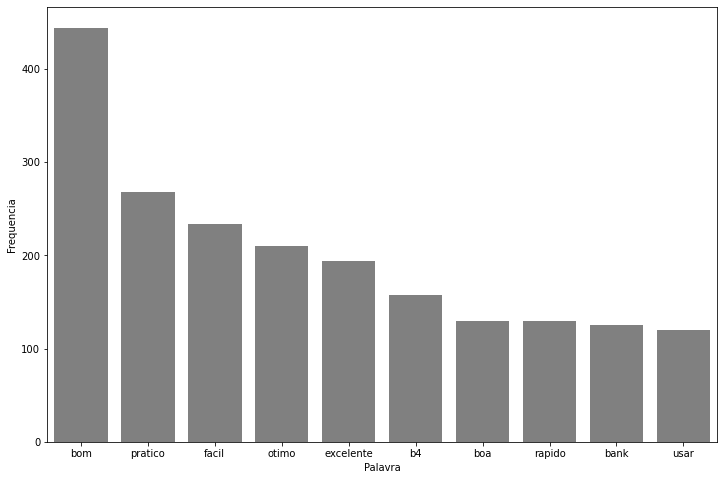

In [30]:
pareto(df_texto, "Trat_Stop", 10)

Aqui podemos ver que as palavras citadas anteriormente tem frequências de aparecimento bem consideráveis.

### Vizualização considerando apenas os casos de sentimento positivo

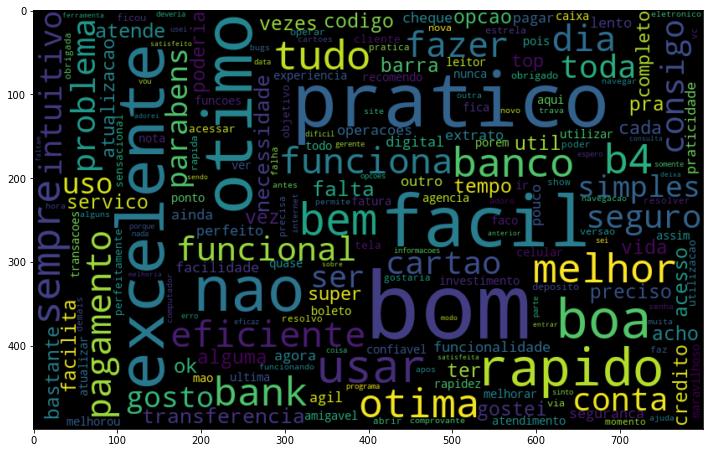

In [31]:
nuvem_pos(df_texto, "Trat_Stop")

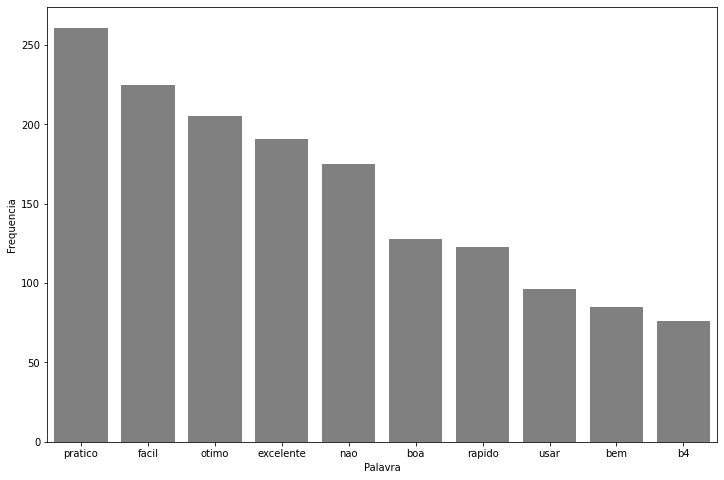

In [32]:
df_texto_positivo = df_texto.query("Sentiment == 'Positive'")
pareto(df_texto_positivo, "Trat_Stop", 10)

### Vizualização considerando apenas os casos de sentimento negativo

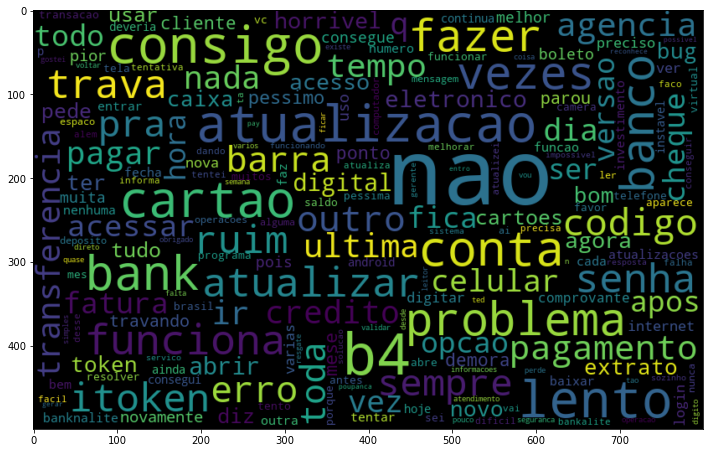

In [33]:
nuvem_neg(df_texto, "Trat_Stop")

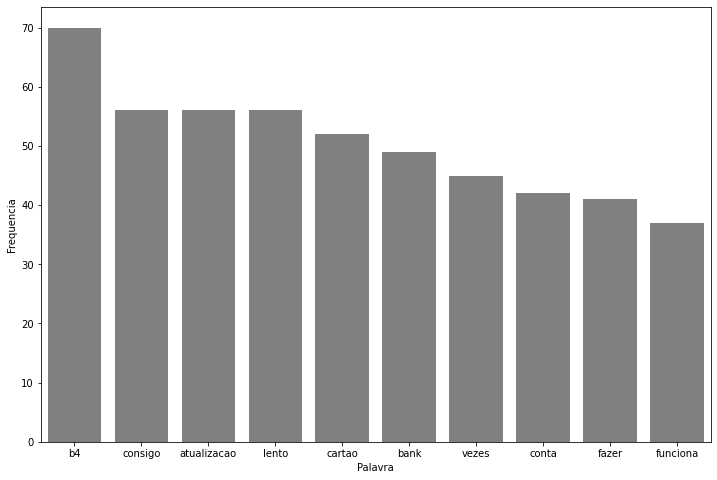

In [34]:
df_texto_negativo = df_texto.query("Sentiment == 'Negative'")
pareto(df_texto_negativo, "Trat_Stop", 10)

Considerando o contexto, podemos ver dois principais problemas no contexto de reviews negativas, os quais possivelmente estão relacionados com problemas com não conseguir fazer algo, problemas após uma atualização e lentidão na execução do APP.

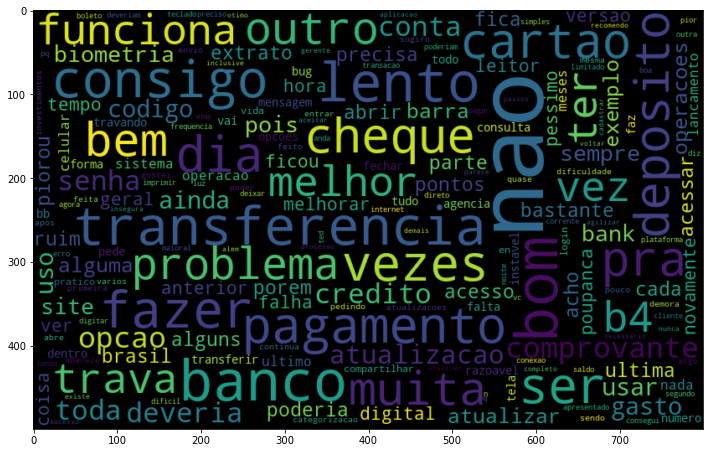

In [35]:
nuvem_net(df_texto, "Trat_Stop")

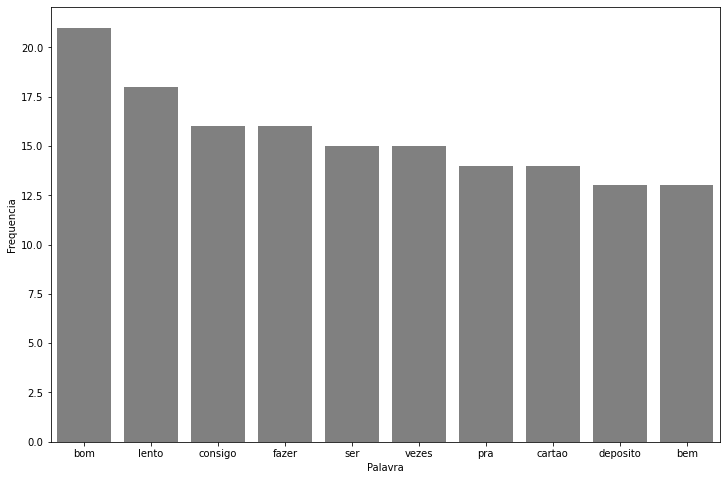

In [36]:
df_texto_neutral = df_texto.query("Sentiment == 'Neutral'")
pareto(df_texto_neutral, "Trat_Stop", 10)

## Análise de Reviews Neutras sobre alguns tópicos

In [37]:
df_texto_net = df_texto.query("Sentiment == 'Neutral'")
busca = df_texto_net["Trat_Stop"]

encontrados = list()

for i, review in enumerate(busca):
    if review.find("pagamento") > 1:
        encontrados.append(i)
    

for j in encontrados:
    if df_texto_net["App Version Name"].iloc[j] == '6.11.1':
        display(df_texto_net["App Version Name"].iloc[j])
        display(df_texto_net["Review Text"].iloc[j])

'6.11.1'

'Diminui minha avaliação de 5 estrelas p/ 3 pois: 1. Pagamentos Detran com falha ao tentar deletar um veículo (o primeiro vai, a partir do segundo trava, tem que fechar e abrir o app novamente) 2. Desnecessário, ao cadastrar um veículo para poder pagar o licenciamento tem que obrigatoriamente ir até uma agência sendo que a maioria dos celulares tem leitura biométrica. 3. Não consigo usar o site no Mac, mesmo instalando com sucesso o guardião, ao re-acessar o site pede novamente para instalar.'

In [38]:
encontrados = list()

for i, review in enumerate(busca):
    if review.find("transferencia") > 1:
        encontrados.append(i)
    

for j in encontrados:
    display(df_texto_net["App Version Name"].iloc[j])
    display(df_texto_net["Review Text"].iloc[j])

'6.10.6'

'Falhas eventuais impedem transferências no mesmo dia.'

'6.10.6'

'O aplicativo no geral é bom. Mas tem problemas graves em alguns pontos. 1- o depósito de cheques é o mesmo deplorável, muito fraco e quase nunca detecta as bordas. 2- seria ótimo se encontrassem uma forma de agilizar as transferências, mas pois 5 passos acho demais.'

'6.10.6'

'Pouco didático. Plataforma de difícil entendimento. Hoje não consegui fazer uma transferência de 120 Reais porque o teclado virtual mudava para 1020 Reais Muito desagradável'

'6.10.9'

'Muito bom para consulta de saldo, pagamento de contas e transferencias. Mas para acompanhar investimentos é extremamente confuso. Nao entendo pq nao fazer uma tela simples onde se possa ver com clareza dados de movimentacao e rendimento. Nem pelo site...'

'6.10.9'

'Mudou a forma de colocar valor para transferências ficou péssimo'

'6.10.6'

'Sempre que minimiza a tela do aplicativo logado ele é desconectado. Muito ruim isso, sempre que faço um pagamento ou transferência e envio o comprovante tenho que logar a cada operação. E a parte de inserir os valores também não é inteligente e sempre tenho que reorganizar os números porque ficam em milhões.'

'6.10.6'

'O app no geral é bom, como sugestão deveria ter opção de valores maiores pré-definidos nas opções de transferência. 50,00 é pouco para quem gosta de usar essa opção e quer transferir, por exemplo, 1000,00. Continua sem as melhorias, já estamos em Setembro e nada foi alterado.'

'6.10.6'

'E bom. Mais nao funciona para servicos depois de meia noite. Transferencia entre bancos diferente nao esta aparecendo opçao de poupança so conta corrente, Exemplo Caixa economica.'

'6.10.6'

'Não consegui compartilhar o comprovante de transferência.'

'6.10.0'

'Poderia melhorar. O leitor de código de barras é ruim e outro dia fiquei quase uma hora tentando me loga para fazer uma transferência importante. Os apps dos outros bancos funcionavam perfeitamente e este ficava tentando carregar o teclado para a senha.'

'6.10.0'

'ultimos 60 dias o app tem apresentado problemas de acesso a algumas funcionalidades, como poupança e demais investimentos, e nas transferências vários "botões" não funcionam de vez em qdo'

'6.10.3'

'app nao possui transferência programada recorrente, obrigado pela resposta porem ainda continuo sem a funcionalidade pois preciso agendar a recorrência para outro banco. no App do meu banco anterior a função estava disponivel para até 18 meses.'

'6.10.3'

'limitado nas operações e falho nas transferências pra outros bancos, principalmente os digitais.'

'6.10.3'

'A opção de envio de comprovantes de TED e transferência via WhatsApp, por exemplo, não é mais permitida através do App. Era uma facilidade importante.'

'6.10.5'

'Durante qualquer transferência, durante várias vezes, percebi que em vez de TED a primeira opção do banco é automaticamente DOC, onde a transferência que foi feito, que era para resolver algum pepino, será adiada para o outro dia, e se for para um socorro imediato? Portanto, sugiro que essa primeira opção automática, seja uma escolha do cliente ou seja TED.'

'6.10.3'

'O app é bom, falta login por biometria. Poderia ter notificação de depósito, transferência e operações no débito e crédito.'

## Construção dos Modelos de Predição

In [39]:
df_texto["Sentiment"].value_counts()

Positive    2144
Negative     438
Neutral      174
Name: Sentiment, dtype: int64

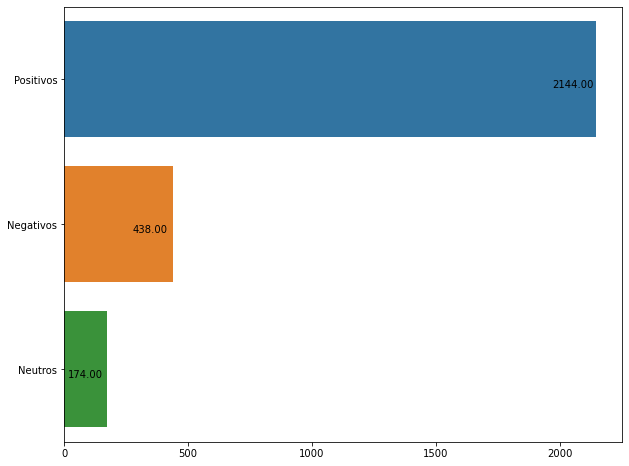

In [40]:
plt.figure(figsize=(10,8))
sns_t = sns.barplot(x=[2144, 438, 174], y=["Positivos", "Negativos", "Neutros"])

for p in sns_t.patches:
    width = p.get_width()
    plt.text(-90+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.2f}'.format(width),
             ha='center', va='center')

### Regressão Logística

In [41]:
SEED = 42
np.random.seed(SEED)

tfifd = TfidfVectorizer(ngram_range=(1,2))

tfidf_bruto = tfifd.fit_transform(df_texto["Trat_Stm"])

x = tfidf_bruto
y = df_texto.Class

treino_x, val_x, treino_y, val_y = train_test_split(x, y, 
                                                    test_size=0.2, 
                                                    stratify=y)

cv = KFold(n_splits=5, shuffle=True);
regressao_logistica = LogisticRegression(max_iter=500, 
                                         penalty="none", 
                                         multi_class="multinomial")

resultados = cross_validate(regressao_logistica, treino_x, treino_y, cv=cv)

imprime_resultados(resultados)

Precisão Média: 84.85%
O intervalo de precisão: 82.69% a 87.01%


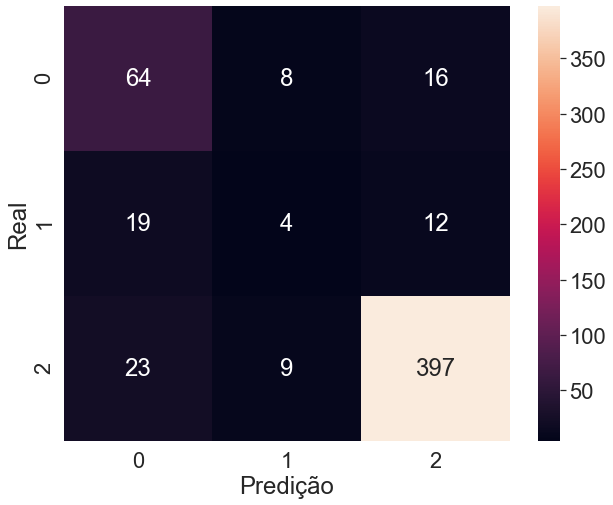

In [42]:
regressao_logistica.fit(treino_x, treino_y)
pred = regressao_logistica.predict(val_x)

conf_matrix = confusion_matrix(val_y, pred)

plt.figure(figsize=(10,8))
sns.set(font_scale=2)
sns.heatmap(conf_matrix, annot=True, fmt='d').set(xlabel='Predição', ylabel='Real');

### MLP Classifier

In [43]:
SEED = 42
np.random.seed(SEED)

tfifd = TfidfVectorizer(ngram_range=(1,2))

tfidf_bruto = tfifd.fit_transform(df_texto["Trat_Stm"])

x = tfidf_bruto
y = df_texto.Class

treino_x, val_x, treino_y, val_y = train_test_split(x, y, 
                                                    test_size=0.2, 
                                                    stratify=y)

cv = KFold(n_splits=5, shuffle=True);

mlp = MLPClassifier(hidden_layer_sizes=[128, 64], 
                    max_iter=500, 
                    activation="relu", 
                    solver="adam")

resultados = cross_validate(mlp, treino_x, treino_y, cv=cv)

imprime_resultados(resultados)

Precisão Média: 84.44%
O intervalo de precisão: 82.87% a 86.00%


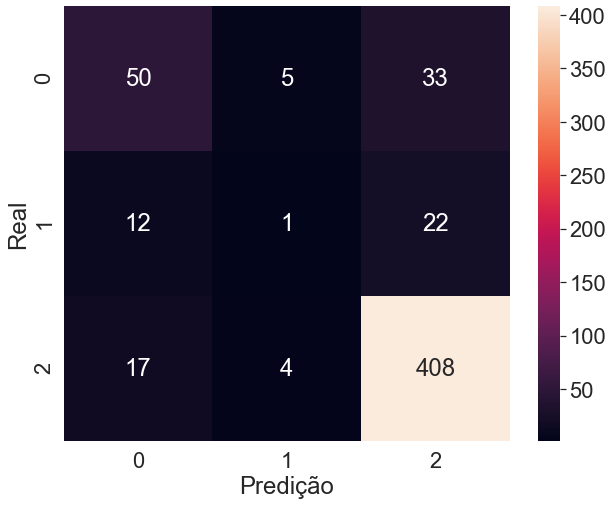

In [44]:
mlp.fit(treino_x, treino_y)
pred = mlp.predict(val_x)

conf_matrix = confusion_matrix(val_y, pred)

plt.figure(figsize=(10,8))
sns.set(font_scale=2)
sns.heatmap(conf_matrix, annot=True, fmt='d').set(xlabel='Predição', ylabel='Real');

## Teste com Dataset mais balanceado

In [45]:
indexNames = df_texto[ df_texto['Sentiment'] == 'Positive' ].index
lista = [t for t in indexNames]

list_of_random_items = random.choices(population=lista, k=2500)

df_balanceado = df_texto.drop(list_of_random_items)
df_balanceado["Sentiment"].value_counts()

Positive    666
Negative    438
Neutral     174
Name: Sentiment, dtype: int64

In [46]:
SEED = 42
np.random.seed(SEED)

tfifd = TfidfVectorizer(ngram_range=(1,2))

tfidf_bruto = tfifd.fit_transform(df_balanceado["Trat_Stm"])

x = tfidf_bruto
y = df_balanceado.Class

treino_x, val_x, treino_y, val_y = train_test_split(x, y, 
                                                    test_size=0.2, 
                                                    stratify=y)

cv = KFold(n_splits=5, shuffle=True);
regressao_logistica = LogisticRegression(max_iter=500, 
                                         penalty="none", 
                                         multi_class="multinomial")

resultados = cross_validate(regressao_logistica, treino_x, treino_y, cv=cv)
imprime_resultados(resultados)

Precisão Média: 75.44%
O intervalo de precisão: 68.12% a 82.75%


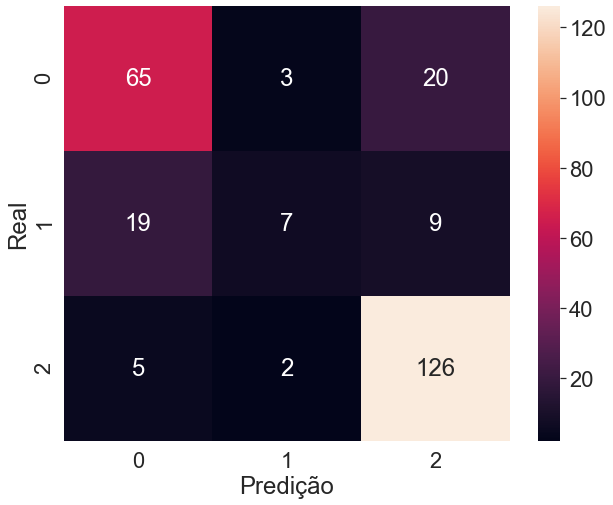

In [47]:
regressao_logistica.fit(treino_x, treino_y)
pred = regressao_logistica.predict(val_x)

conf_matrix = confusion_matrix(val_y, pred)

plt.figure(figsize=(10,8))
sns.set(font_scale=2)
sns.heatmap(conf_matrix, annot=True, fmt='d').set(xlabel='Predição', ylabel='Real');

In [48]:
SEED = 42
np.random.seed(SEED)

tfifd = TfidfVectorizer(ngram_range=(1,2))

tfidf_bruto = tfifd.fit_transform(df_balanceado["Trat_Stm"])

x = tfidf_bruto
y = df_balanceado.Class

treino_x, val_x, treino_y, val_y = train_test_split(x, y, 
                                                    test_size=0.2, 
                                                    stratify=y)

cv = KFold(n_splits=5, shuffle=True);

mlp = MLPClassifier(hidden_layer_sizes=[128, 64], 
                    max_iter=500, 
                    activation="relu", 
                    solver="adam")

resultados = cross_validate(mlp, treino_x, treino_y, cv=cv)

imprime_resultados(resultados)

Precisão Média: 74.46%
O intervalo de precisão: 66.03% a 82.89%


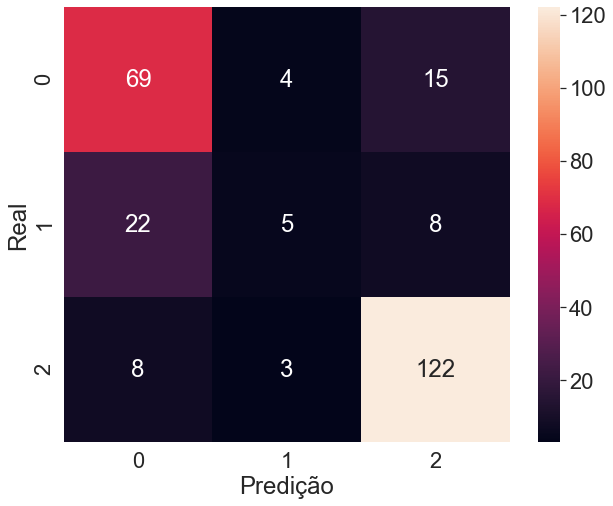

In [49]:
mlp.fit(treino_x, treino_y)
pred = mlp.predict(val_x)

conf_matrix = confusion_matrix(val_y, pred)

plt.figure(figsize=(10,8))
sns.set(font_scale=2)
sns.heatmap(conf_matrix, annot=True, fmt='d').set(xlabel='Predição', ylabel='Real');

## Teste de classificação com a remoção das Reviews Neutras

In [50]:
index_net = df_balanceado[ df_balanceado['Sentiment'] == 'Neutral' ].index

df_balanceado_sem_neutro = df_balanceado.drop(index_net)
df_balanceado_sem_neutro["Sentiment"].value_counts()

Positive    666
Negative    438
Name: Sentiment, dtype: int64

In [51]:
SEED = 42
np.random.seed(SEED)

tfifd = TfidfVectorizer(ngram_range=(1,2))

tfidf_bruto = tfifd.fit_transform(df_balanceado_sem_neutro["Trat_Stm"])

x = tfidf_bruto
y = df_balanceado_sem_neutro.Class

treino_x, val_x, treino_y, val_y = train_test_split(x, y, 
                                                    test_size=0.2, 
                                                    stratify=y)

cv = KFold(n_splits=5, shuffle=True);
regressao_logistica = LogisticRegression(max_iter=500, 
                                         penalty="none", 
                                         multi_class="multinomial")

resultados = cross_validate(regressao_logistica, treino_x, treino_y, cv=cv)
imprime_resultados(resultados)

Precisão Média: 87.88%
O intervalo de precisão: 84.50% a 91.26%


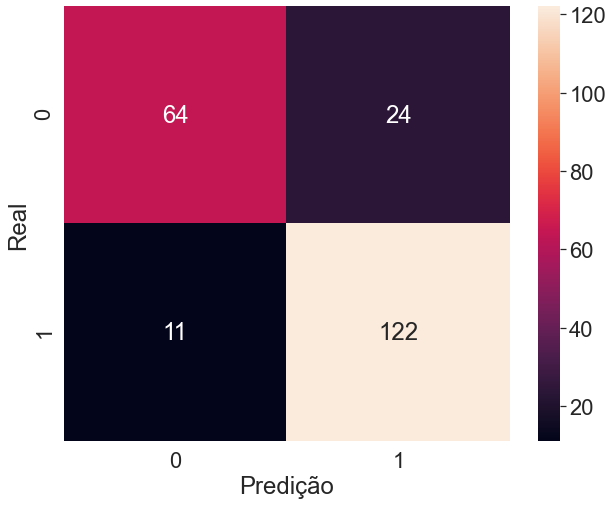

In [52]:
regressao_logistica.fit(treino_x, treino_y)
pred = regressao_logistica.predict(val_x)

conf_matrix = confusion_matrix(val_y, pred)

plt.figure(figsize=(10,8))
sns.set(font_scale=2)
sns.heatmap(conf_matrix, annot=True, fmt='d').set(xlabel='Predição', ylabel='Real');

In [53]:
SEED = 42
np.random.seed(SEED)

tfifd = TfidfVectorizer(ngram_range=(1,2))

tfidf_bruto = tfifd.fit_transform(df_balanceado_sem_neutro["Trat_Stm"])

x = tfidf_bruto
y = df_balanceado_sem_neutro.Class

treino_x, val_x, treino_y, val_y = train_test_split(x, y, 
                                                    test_size=0.2, 
                                                    stratify=y)

cv = KFold(n_splits=5, shuffle=True);

mlp = MLPClassifier(hidden_layer_sizes=[128, 64], 
                    max_iter=500, 
                    activation="relu", 
                    solver="adam")

resultados = cross_validate(mlp, treino_x, treino_y, cv=cv)

imprime_resultados(resultados)

Precisão Média: 87.31%
O intervalo de precisão: 83.06% a 91.57%


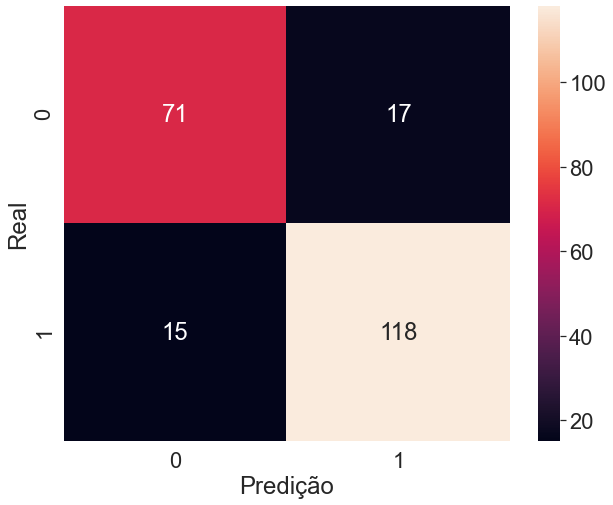

In [54]:
mlp.fit(treino_x, treino_y)
pred = mlp.predict(val_x)

conf_matrix = confusion_matrix(val_y, pred)

plt.figure(figsize=(10,8))
sns.set(font_scale=2)
sns.heatmap(conf_matrix, annot=True, fmt='d').set(xlabel='Predição', ylabel='Real');